In [1]:
## Install packages
install.packages("here")    
library(here)

Installing package into 'C:/Users/ts2934/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'here' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ts2934\AppData\Local\Temp\Rtmp2Lae7u\downloaded_packages


here() starts at C:/Users/ts2934/git/macro-finance-lectures



In [2]:
here()

[1] "C:/Users/ts2934/git/macro-finance-lectures"

In [24]:
packages <- c("ggplot2", "tidyverse", "readstata13", "stringr")

source(here("src/check_packages.r"))
check_packages(packages) # Check whether packages are installed already and load them 

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

In [7]:
# Load and inspect data 
path_data <- here("data/")
div_raw   <- readRDS(file = here(path_data, "sp500_dividends.rds")) 
price_raw <- readRDS(file = here(path_data, "sp500_prices.rds"))

head(div_raw)
head(price_raw)

,Date,Value
,<date>,<dbl>
1,2021-06-30,58.14
2,2021-03-31,58.11
3,2020-12-31,61.08
4,2020-09-30,58.84
5,2020-06-30,59.99
6,2020-03-31,59.18


,Date,Value
,<date>,<dbl>
1,2021-09-01,4524.09
2,2021-08-31,4522.68
3,2021-07-01,4319.94
4,2021-06-30,4297.50
5,2021-06-01,4202.04
6,2021-04-30,4181.17


In [11]:
# Some initial settings 
curr_year   <- as.double(format(Sys.Date(), "%Y")) # don't change this
first_year  <- 1871
last_year   <- 1979  # can be different from current year, but must be larger than first year
          

In [12]:
########### DATA PREP #################
# Read data first
div   <- div_raw
price <- price_raw

# Prep data: Dividends
div$month <- as.double(format(div$Date, "%m"))
div$year <- as.double(format(div$Date, "%Y"))
div <- subset(div, (year <= last_year & year >= first_year))
div <- div[order(div$Date), ]
div <- div %>%  # There may be multiple observations per year - we will choose the first observation of every year 
    group_by(year) %>%
    filter(row_number() == 1)
div$Date <- format(div$Date,"%Y")
div <- div %>% rename(div = Value) %>% select(-c("month", "year"))

# Prep data: Prices
price$month <- as.double(format(price$Date, "%m"))
price$year <- as.double(format(price$Date, "%Y"))
price$day <- as.double(format(price$Date, "%d"))
price <- subset(price, (year <= last_year & year >= first_year))
price <- price[order(price$Date), ]
price <- price %>%  # There may be multiple observations per year so we need to choose the last observation of every year 
         group_by(year) %>%
         filter(row_number() == 1)

price$Date <- format(price$Date,"%Y")
price <- price %>% rename(price = Value)
price <- price %>% select(-c("day", "month", "year"))

## Add interest rates from JST database (not required for the Shiller graph)
rawdata <- read.dta13(here(path_data, "JSTdatasetR5.dta"))
myvars <- c("year", "country", "cpi", 
            "stir",  # short-term gov bills
            "ltrate" # long-term gov bonds
)
rates <- rawdata[rawdata$country == "USA", myvars]
rates <- rates %>% 
        rename(Date = year)  %>% 
        mutate(Date = as.character(Date),
               stir = stir/100,
               ltrate = ltrate/100)

## Merging and indexing
df <- left_join(div, price, by = "Date")
df <- left_join(df, rates, by = "Date")

df$Date <- as.Date(df$Date, format = "%Y")
df$year <- as.double(format(df$Date, "%Y"))
df <- df[order(df$year), ] # Note: the data must be ordered in increasing order of time for the Shiller algo to work 

df <- df %>%
        mutate(div_index   = div/div[year == first_year]*100) %>%
        mutate(price_index = price/price[year == first_year]*100) %>%
        mutate(infl = (cpi/lag(cpi, 1) - 1)) %>%             # inflation defined as growth in yearly CPI inflation 
        mutate(stir_real = (1 + stir) / (1 + infl) - 1) %>%  # deflate nominal shot-term interest rates
        mutate(ltrate_real = (1 + ltrate) / (1 + infl) - 1) %>% # deflate nominal long-term interest rates
        mutate(price_div_ratio = price / div,
               div_price_ratio = div / price) %>%
        mutate(price_lead5 = lead(price, n = 5),
            annual_return_5yr = (price_lead5/price)^(1/5) - 1,   # real annual returns
            annual_return_5yr_minus_stir = annual_return_5yr - stir_real,  
            annual_return_5yr_minus_ltrate = annual_return_5yr - ltrate_real, 
            year = as.double(format(Date, "%Y")),
            ) %>%
        mutate(return_5yr = (1 + annual_return_5yr)^5 - 1,       # real returns over the whole period
               return_5yr_minus_stir = (1 + annual_return_5yr_minus_stir)^5 - 1,
               return_5yr_minus_ltrate = (1 + annual_return_5yr_minus_ltrate)^5 - 1)



Adding missing grouping variables: `year`

Adding missing grouping variables: `year`



In [16]:
## Shiller method of detrending data and constructing PV of dividends

# Compute long run exponential growth rate (last observation - first observation)
g <- (df[df$year==last_year, "price"] / df[df$year==first_year, "price"]) ^ (1/(nrow(df)-1)) - 1

# Detrend prices
df$price_detrended <- df$price
for (i in 1:nrow(df)) {
    df[i, "price_detrended"] <- df[i, "price_detrended"] / (1+g)^(i-nrow(df))
}

# Detrend dividends
df$div_detrended <- df$div
for (i in 1:nrow(df)) {
    df[i, "div_detrended"] <- df[i, "div_detrended"] / (1+g)^(i-nrow(df))
}

# Compute constant discount rate as the mean yield of stocks over chosen period
r <- mean(df$div_detrended) / mean(df$price_detrended)

# Set terminal price 
tp <- mean(df$price_detrended)

# Compute fundamental values
df$p_star <- df$price_detrended
df[nrow(df),"p_star"] <- tp
for (i in (nrow(df)-1):1) { 
    df[i,"p_star"] = (df[i+1,"p_star"] + df[i,"div_detrended"]) / (1 + r)
}


[1] 0.04616419

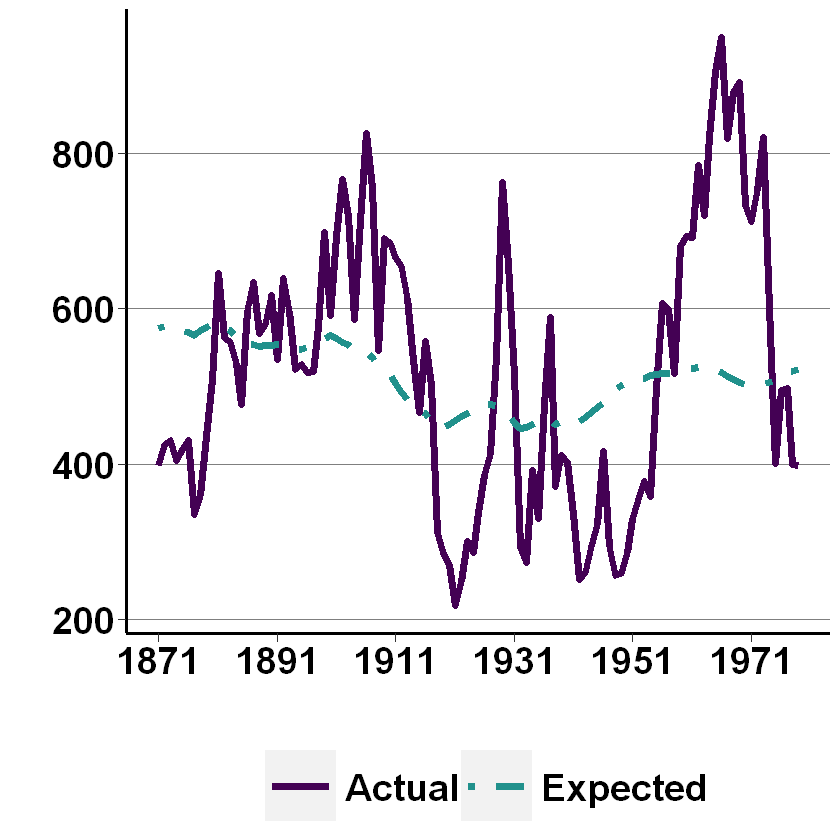

In [17]:
## PLOTTING Shiller graph
# load the formatting and saving settings from another script
source(here("src/format_plots.r"))
source(here("src/save_plots.r"))

if (last_year - first_year <= 60) {
    xticks = 10
} else {
    xticks = 20
}
xlimits <- c(as.double(first_year), as.double(format(Sys.Date(), "%Y")))

# Wide to long format (better for ggplot)
df_tmp <- df %>%
           select(c("price_detrended", "p_star", "year")) %>%
           pivot_longer(c("price_detrended", "p_star"), names_to = "series", values_to = "value") 
df_tmp$series <- gsub("price_detrended", "Actual", df_tmp$series, fixed = TRUE)
df_tmp$series <- gsub("p_star", "Expected", df_tmp$series, fixed = TRUE)

ggplot(data = df_tmp, aes(x = year, y = value)) +
    geom_line(aes(color = series, linetype = series), size = 2) +
    scale_x_continuous(breaks=seq(xlimits[1], xlimits[2], xticks)) +
    labs(y = "", x = "", title = "") + 
    format +
    scale_linetype_manual(values = c("solid", "dotdash")) +
    scale_color_manual(values = c(purple, green))


In [23]:
## Compare with the original plot 
## "https://2.bp.blogspot.com/-OG60TWSLCwE/Ul3o0pChdrI/AAAAAAAAAkg/uE2vGx8TarY/s1600/Shiller.PNG"